# Practical Data Science -  Assignment I                   

## *Vasileios Galanos, 10/2019*

### Part 1: Scraping Twitter Accounts

### 1.1 Connect to Twitter

* We import the credentials we were given with our Twitter app registration from the file `twitter_config.py`(located in the same folder as this notebook) and use them with the tweepy library in order to access the **Twitter API**.  
* We also import some important libraries that we will use later.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import random
import numpy as np

%matplotlib inline

In [2]:
import tweepy
from twitter_config import config

auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth)

We then use [GET trends/place](https://developer.twitter.com/en/docs/trends/trends-for-location/api-reference/get-trends-place) with the WOEID that corresponds to Athens in order to get the top 50 trending topics.

In [3]:
ATHENS_WOE_ID = 946738
athens_trends = api.trends_place(id=ATHENS_WOE_ID)[0]['trends']

Creating an empty list and appending only values that correspond to *Trend Name* and *Tweet Volume*. We also remove any hashtags from *Trend Name*

In [4]:
trends_list = []
for trend in athens_trends:
        trends_list.append([re.sub('#','',trend["name"]),trend['tweet_volume']])

We can print the first 10 elements in the list as below, but we can use `tweet_volume` as well, a brand new addition to Twitter API that is the volume of tweets per trend for the last 24 hours.

In [5]:
for trend,vol in trends_list[:10]:
    print(trend)

CSKOLY
globetrottersgr
πατρα
GNTMgr
παρελαση
Monty Python
kalomesimeraki
Αρμενιων
σουζανα
Βουλης


Creating a **pandas** dataframe from the previous list is handy, mainly because of the following data transformations:

In [6]:
df = pd.DataFrame(trends_list, columns=['trend','volume']) #creating the dataframe
df.loc[np.isnan(df['volume']),'volume'] = 0 #replace None with 0
top_trends = df.sort_values('volume', ascending = False ).trend.head(10) #getting only the top 10 trends ordered by volume

Printing the results ordered by `tweet volume`:

In [7]:
print(*top_trends, sep='\n')

Halloween
ThankYouBTS
Happy Halloween
tories
loveyourselfforever
AfiliAşk
AyKer
επρεπε
Βοριδη
η βουλη


### 1.2 Username Scraping

* Using the requests library, we make an **HTTP GET** request to the website that contains the information that we want to scrape and store the response. 
* We use *try - except* in case there are any exceptions that will produce errors.
* Finally we pass the html contents through the BeautifulSoup library in order to navigate the data structure.

In [8]:
try:
    r = requests.get("https://www.businessinsider.com/uk-politics-twitter-accounts-2016-8?r=US&IR=T")
except requests.exceptions.RequestException as rex:
    print(rex)
else:
    print("Page retrieval OK")
    
html = r.content
soup = BeautifulSoup(html, 'html.parser')

Page retrieval OK


* Discovering patterns in a html document is the key for a succesfull data scraping. Here the **<h2\>** tag helps us locate every twitter user. 
* Using `parent` and `findNextSibling` we manage to scrape the Twitter Username.
* Finally we clean the strings using a Regular Expression and store them in a list.

In [9]:
usernames = []

for row in soup.body.findAll("h2", {"class": "slide-title-text"}):
    parent = row.parent
    tw_acc = re.sub('\w+:\s*@','',parent.findNextSibling("p").get_text())
    usernames.append(tw_acc)
    
usernames[:3]

['Tom_Slater_', 'MattSingh_', 'asabenn']

### 1.3 Fetch Tweets

* We want to fetch the tweets posted in the last 24 hours for each of the usernames that we scraped.
* Below, we find the datetime before exactly 24 hours.

In [10]:
from datetime import datetime, timedelta
last_day = datetime.utcnow() - timedelta(hours = 24)
print (last_day)

2019-10-29 20:05:19.611742


* We use the following function as a handler to avoid running into a [rate limit](https://developer.twitter.com/en/docs/basics/rate-limiting) using the Twitter API. 
* If we do, though, hit a rate limit, waiting 15 minutes will reset any penalties.

In [11]:
import time

def limit_handler(cursor):
    while True:
        try:
            yield cursor.next()
            # This is to avoid running into a rate limit
            time.sleep(60)
        except tweepy.RateLimitError:
            # But if we do run into a rate limit, then
            # go to sleep for 15 minutes
            print('Rate limit reached')
            time.sleep(15 * 60)
        except tweepy.TweepError as te:
            if te[0]['code'] == '419':
                print('Requests limit reached')
                time.sleep(15 * 60)
            else:
                raise

The following `print_tweets` function, takes two parameters: 
* a target user for whom we will print the tweets
* a datetime object that will be used to print only tweets newer than that. The Twitter API fetches tweets from the newest to the oldest, so we break the process if we find a tweet that is older than this date.

We use [GET user_timeline](https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline) to fetch no more than 100 tweets at a time.
* Using `max_id` as a parameter, is crucial in order to avoid getting duplicates while we're fetching pages of results (in case the user tweeted while we were fetching the next page. ([See how timelines work](https://developer.twitter.com/en/docs/tweets/timelines/guides/working-with-timelines))
* The function returns a `counter` with the number of tweets that we fetched and a `max_border` containing the id of the newest tweet in all the tweets that we processed.

In [12]:
def print_tweets(target_user,last_day):
    print('@',target_user,' tweeted: ',sep='')
    tweet_ids = []
    border = None
    max_border = None
    counter = 0
    for page in limit_handler(tweepy.Cursor(api.user_timeline
                           ,screen_name = target_user
                           ,count=100
                           ,max_id = border
                           , include_rts = False
                         ).pages()):
        for tweet in page:
            
            if tweet.created_at < last_day:
                return(counter,max_border)
            
            print(tweet.text)
            tweet_ids.append(tweet.id)
            counter+=1
            max_border = max(tweet_ids)
            
        border = min(tweet_ids)-1
        print('Loading next page...')

With `print_new_tweets` function, we are trying to fetch any new tweets the user tweeted while we were fetching the pages with the results. Using the `since_id` parameter with `max_border` containing the id that we explained earlier, allows us to fetch any new tweets efficiently. We do not use pagination or a handler this time, because we trust that the user didn't tweet that much in so little time.

In [13]:
def print_new_tweets(target_user,last_day,limit):
    counter2 = 0
    for tweet in tweepy.Cursor(api.user_timeline
                           ,screen_name = target_user
                           ,count=100
                           ,since_id = limit
                           , include_rts = False
                         ).items():
        if tweet.created_at >= last_day:
            print(tweet.text)
            counter2+=1
    return(counter2)
        

Now it is time to print the results.
* Using *try-except* and `get_user` safely guarantees us that the process will not crash for a single user that may not exist.

In [14]:
for user in usernames:
    try:
        api.get_user(user)
        c,s = print_tweets(user,last_day)
        print('-----'*5,'fetched: ',c,' tweets..','-----'*5)  
        c = print_new_tweets(user,last_day,s)
        if (c >0): 
            print('-----'*5,'While processing.. @',user,' fetched: ',c,' new tweets','-----'*5)           
    except Exception as err:
        print('-----'*5,'Cound not fetch','@'+user,'-----'*5)

@Tom_Slater_ tweeted: 
------------------------- fetched:  0  tweets.. -------------------------
@MattSingh_ tweeted: 
Sad to hear that my MP is standing down, and particularly of the circumstances. Let's hope her successor continues… https://t.co/uH1wtrhdXq
@AndyCroy Not sure, but presumably it does?
Depends which ones they are. If they're Lab-Con marginals, the impact the very different than if they're solidly La… https://t.co/lQQPIqsRWU
Leicester East constituency poll anyone?🤔 https://t.co/sWBQGf5rG7
@ChristabelCoops Raaar🦁 https://t.co/C3aEI8KURO
@ChristabelCoops Don't you have some barrels to make?🤔
@ben_jolley2 @HenryTribe Yes, although that was totally unexpected, whereas this one has been talked about for a while
@sundersays Sorry, 8 points
@sundersays Hartlepool... UKIP came within 6 points of LAB in 2016 on a similar vote share to BXP’s current polling
@HenryTribe Applying to register, not registering
@AnneAshworth Not yet, but watch this space! Here's some analysis of 2017.

@LadPolitics tweeted: 
@davidrobbo66 which ones?
@jamesrbuk Sure, here is the latest. https://t.co/gERuufqz87
@georgegalloway @AbiWilks https://t.co/PVh9nGOz8X
@AbiWilks 50/1, if you fancy betting on it.
@LeftieStats I don't expect the European election results to correlate very closely to what happens on Dec 12th tbh
@LeftieStats I expect her odds will be shorter than Labour i.e. she'll be given a higher chance of winning.
@Ozzysmith1 but he might be speaker by then, so that would obv make a difference
@Ozzysmith1 no, that'll have to wait.
George Galloway is 7/1 to unseat Tom Watson in West Brom East. https://t.co/P6phPZUmNv
@AdamPritchard82 @steve_jolly There is the precedent of 2001 when the election had to be delayed from the planned d… https://t.co/YUlX5NqHso
@AdamPritchard82 @steve_jolly Hmm, well generally we'd like to pay out asap, but at a minimum it'll need to get thr… https://t.co/meltp3d0qt
@steve_jolly it's on the list! Can't promise when, but will be available at some poi

@ravsgill I wasn’t suggesting voting Labour....
@OjazzO @Barnabyspeak Have a little think and you might work it out. Or not. ;)
@OjazzO @Barnabyspeak Thanks for missing the point. Not needed either. 👍
@nickbeddows Which is fair enough, but not really the point. They’re *not* going to dump him.
@OjazzO @Barnabyspeak Say it if you like. If you like pissing into the wind, particularly. :)
@CliveWismayer @Maxmycat Very white smoke indeed.
@barneyc Sigh.....
@LeftWingKav Of course, but failing to end Brexit makes it all-but-impossible to reverse austerity for decades.
How will UKIP survive without Dick Braine? https://t.co/VF1m4B7hcV
@StevePeers Now only Cleverly remains to fight the good fight against it.
Why I won’t be lamenting the loss of Amber Rudd...... https://t.co/1uZV8tvR7R
@andraswf @almostconverge We have a great Arabic supermarket in Cambridge with really excellent spices. The best Iranian saffron.....
@RealBristolBoy I was really talking about all those people bleating ‘if only

@youngvulgarian tweeted: 
Actually, one interesting stat - female MPs represent 20% of the current Tory benches but 25% of the ones resigning… https://t.co/GOILzTQUiF
Okay I've just had a quick look and female MPs represent 32% of this Parliament and currently 31% of the resignatio… https://t.co/xbBl9M6aep
Has anyone crunched the numbers on the percentage of female MPs in this parliament vs the percentage of female MPs… https://t.co/PP9lfNFhEh
@antoniabance Hah! Also good not food, the autocorrect on my new phone is driving me mad
@antoniabance (and I don't love Blu but I think I want to adopt her? she's so sweet!)
@antoniabance Nooo I love the chest hair! And I find Bagga irritating, though food we can agree on The Vivienne
@FCDWhittaker No it's just you I think, sorry
@antoniabance Yes! I've always been more on the side of the edgy fashion queens tbh - who's your fave?
@alilaw_UK True, true, I did feel very powerful
am I having a stroke https://t.co/63Qr30sbwh
@GrantTucker Hang on, I

@IanDunt tweeted: 
@lyman_brian Oh, me too.
That and whenever they show a baseball bit. It always goes slow-mo for the throwy-hitty bit and then I'm like: What… https://t.co/AFu3Okfqh4
Also always the worst part of American TV series.
I thought the Americans were supposed to be the ultimate materialists. They've fucked that one right up.
Still don't get Thanksgiving. It just sounds like Christmas but without the presents.
@ChantayyJayy @Miss_Toppin Cheers both. Welcome to pitch me at ian.dunt@politics.co.uk.
As @anandMenon1 said a while back, a Corbyn in Sturgeon's pocket poster would be very compelling to a lot of Remain… https://t.co/0J4gnK15fA
@hugorifkind But that was the only reason I liked it.
Watching Tory MPs nod sagely every time Johnson says the machine programmed 'dither and delay' lines is really something.
What a way to go, really. For someone of Clarke's stature and history to leave the Commons an independent, chucked… https://t.co/XTRmvi1Jao
He either refused to pay his 

@PatrickStrud tweeted: 
------------------------- fetched:  0  tweets.. -------------------------
------------------------- Cound not fetch @NadineDorriesMP -------------------------
------------------------- Cound not fetch @jreedmp -------------------------
@stephenkb tweeted: 
@tom_usher_ Torreira’s goal is a vindication of Emery’s attempts to play him as a 10.
@theo_barclay @ollywiseman Also: Oh Mercy and Infidels.
@tom_usher_ If I were Unai Emery, I would simply pick our best players in their correct positions.
@CJTerry I did!
@dirk1978 They’re visibly better at spinning broadcasters than May.
@adampudvine Wow! Deep stuff. I never considered it like that before.
@rayman3412 Agree. A fair bit of evidence this happened in some places in 2017.
@Glostermeteor @patrickkmaguire @UKLabour Eh? The supposed influence is meant to be the other way round.
Nice by @patrickkmaguire on the looming CWU strike and its impact on postal ballots. https://t.co/7tLKQdmLQB
@ols_bxl Sure, but on this one

@jakebowman_ I really want to come back to the UK for it but the doctor said not to travel before the baby has her… https://t.co/0QXG8KcMSa
Idk you but I’m genuinely buzzing
@Redman443 I saw the polls in 2017
Corbyn4PM Bernie4Prez
@joe_oliver Yeah! Will DM
I BELIEVE THAT WE WILL WIN
@joe_oliver Are you here now?
------------------------- fetched:  79  tweets.. -------------------------
------------------------- Cound not fetch @jessphillips  -------------------------
@SamCoatesTimes tweeted: 
------------------------- fetched:  0  tweets.. -------------------------
@toadmeister tweeted: 
@JamesDelingpole and I just recorded our latest @calling_podcast. Topics covered include Joker, Watchmen, the WaPo… https://t.co/SIHAGiUnCX
@DouglasCarswell The funny thing about the “mansion” tax is that Corbyn’s Islington home will probably be designate… https://t.co/xG6wGzkAe5
@Tre_Animation @cjsnowdon @aynrandcentre @DouglasCarswell @yaronbrook @Lugey6 @AndrewBoff @aynrand_global If you ca… https:/

@DPJHodges tweeted: 
@GreenLi66832774 Never.
Lot of moderate Tory MPs leaving the party. Classic Dom.
A possible Winter Bed Crisis is actually one of the reasons Tory strategists wanted an early election, and Labour w… https://t.co/quobKeERV9
*NARRATIVE ALERT*   We officially have the first narrative of the 2019 election. Boris has made a terrible blunder.… https://t.co/y8H6Mi4wne
Lots of people say PMQs doesn’t matter. Boris had better hope they’re right because that was Corbyn’s best ever performance.
Number of Tory strategists nervous about No.10 strategy of taking fight to Labour on their NHS turf. This PMQs exch… https://t.co/ScwvFN8Uib
Corbyn actually holding his own here.
One thing we know from this PMQs. Jeremy Corbyn doesn’t want a Brexit election.
Jeremy Corbyn enjoying himself at PMQs. De-mob happy?
Boris can win this election. But if he does, he's going to have to have a long hard think about what sort of party… https://t.co/JoQWAD9g7E
This is the first election campaign I 

@montie tweeted: 
Seconded. Years ago I worked closely with @DLidington on what evolved into @csjthinktank. He was patient, loyal and… https://t.co/ajn72MiU1z
We disagree on #Brexit but @AmberRuddHR is one of the great champions of one nation conservatism and I hope she’ll… https://t.co/B5ox8dsoHe
⬇️🎯 https://t.co/V0oXxlhyOR
------------------------- fetched:  3  tweets.. -------------------------
@britainelects tweeted: 
North East Somerset Westminster voting intention:

CON: 44% (-10)
LDEM: 28% (+20)
LAB: 14% (-20)
BREX: 7% (+7)
GRN:… https://t.co/7yZf9NMlOr
Leamington Lillington (Warwick) result:

LDEM: 55.3% (+7.1)
CON: 28.3% (+11.1)
LAB: 16.4% (-5.5)

Liberal Democrat… https://t.co/KeorueH1o0
House of Commons vote on the Early Parliamentary General Election Bill at Third Reading:

AYES: 438
NOES: 20

Gener… https://t.co/dsPYuz5dhN
Media! Our poll tracker is available for use. Pop us a DM for the code and/or data, or email:

walker[at]https://t.co/QzghnN5ONi
[Admin update]

Our web

@Kevin_Maguire tweeted: 
I like Ken Clarke personally but fawning tributes airbrush his record incl belittling ambulance crews 1989-90(Healt… https://t.co/1zX36sLEes
Tory MPs laughing at Corbyn’s bright green Grenfell tie are an out of touch elite inviting a kick in the ballots. D… https://t.co/4RQMGNHh5Q
Johnson's bad Brexit costing the UK economy £70bn is why the Treasury refused to assess the impact. It’s lousy https://t.co/7q2sPa8A7k
Every one of these will worry Tory strategists: “10 ways Labour can win this year's General Election.” https://t.co/qyc7KDqrm8
Johnson loses the election fif he fails to win a Tory majority while Corbyn could lose seats and still win if Labou… https://t.co/WVww00A4IA
Graceful acknowledgement she was wrong from an inspiring campaigner for decency and respect. https://t.co/9cMHhPA3L2
Smart, talented and decent. Labour can’t afford to lose MPs like @OwenSmith_MP https://t.co/Q91vv8DvDg
Doesn't Priti Patel pose as strong on law and order? https://t.co/5Unw

------------------------- Cound not fetch @tom_watson  -------------------------
------------------------- Cound not fetch @faisalislam  -------------------------
------------------------- Cound not fetch @paulmasonnews  -------------------------
@MhairiBlack tweeted: 
We will go to the polls on 12th December. Let’s show Boris that Scotland is having absolutely none of it. 🏴󠁧󠁢󠁳󠁣󠁴󠁿 https://t.co/fpbev85awG
------------------------- fetched:  1  tweets.. -------------------------
@OwenJones84 tweeted: 
The choice in this election is clear: either a hard Brexit and Thatcherism on steroids, or the end of a pro-rich co… https://t.co/ux4anyQwEK
Best For Boris Johnson more like, @BestForBritain
Absolutely incredible. @BestForBritain - supposedly committed to Remain, headed by a Lib Dem - has set up a tactica… https://t.co/zadkSE8G0q
A decade of Tory rule has been a story of decline and crisis. Now it’s time to defeat the vested interests holding… https://t.co/bcSh3eWX07
A Tory voter rang in to

### Part 2: Processing Twitter accounts

### 2.1 Scrape and Put in a `DataFrame`

In a similar way as before, we store the html content of the website that contains the list of UK MPs with active Twitter accounts organised by their party.

In [15]:
try:
    r = requests.get("https://www.mpsontwitter.co.uk/list")
except requests.exceptions.RequestException as rex:
    print(rex)
else:
    print("Page retrieval OK")
    
html = r.content
soup = BeautifulSoup(html, 'html.parser')

Page retrieval OK


* Discovering a pattern in the way the data is stored, allows us to properly scrape the information that we need.
* This time the information is stored in html tables with **<tr\>** corresponding to the rows of the table, and **<td\>** in the columns.
* The information is then stored to a list of tuples.

In [16]:
container = soup.body.find_all('div',{'class': 'table-responsive'})[1]
my_table = container.find("table", {"class": "table table-striped table-hover"})
mp_members = []
try:
    for tr in my_table.find_all('tr'):
        cols = tr.find_all('td')  
        if (len(cols)==10):
            mp_members.append((
               cols[2].get_text().strip(),
               cols[3].get_text().strip(),
               cols[4].get_text().strip(),
               cols[5].get_text().strip(),
               cols[6].get_text().strip())
              )
except:
    pass

* We put the contents of the list to a `dataframe`, and rename the columns accordingly.
* Also we transform the data type of the `num_followers` column to be numeric.

In [17]:
df = pd.DataFrame(mp_members,
                  columns = ['name', 'username', 'constituency', 'party', 'num_followers'] )
df['num_followers'] = pd.to_numeric(df['num_followers'].str.replace(',',''))

### 2.2 Create a Hierarchical Index

* A MultiIndex object is basically an array of tuples where each tuple is unique. It is a great tool for working with higher dimensional data.
* We can make a MultiIndex object using the columns of a dataframe as follows:

In [18]:
pd.MultiIndex.from_frame(df[['party','num_followers']])

MultiIndex([(         'Conservative',  14960),
            (         'Conservative',  26107),
            (         'Conservative',   8337),
            (         'Conservative',   8998),
            (         'Conservative',  15088),
            (         'Conservative',   3335),
            (         'Conservative',   8411),
            (         'Conservative',  17555),
            (         'Conservative',  13743),
            (         'Conservative',   7752),
            ...
            (            'Sinn Fein',   6530),
            (            'Sinn Fein',  16767),
            (            'Sinn Fein',   4309),
            (            'Sinn Fein',   5357),
            (            'Sinn Fein',  15217),
            ('The Independent Group',  20643),
            ('The Independent Group', 197417),
            ('The Independent Group',  51609),
            ('The Independent Group',  19493),
            ('The Independent Group',  42805)],
           names=['party', 'num_followers']

* Or we can simply use `set_index` with the columns that we want:
* Using `inplace=True` modifies the DataFrame in place (does not create a new object).

In [19]:
df.set_index(['party','num_followers'], inplace=True)

We use this Hiearchical Index to sort the data

In [20]:
df.sort_index(inplace=True)

We then show a sample of the dataframe, showing only the username column:

In [21]:
df.username

party                  num_followers
Conservative           0                 @AndrewBowieMP
                       513              @maggie_erewash
                       878              @SirRogerGaleMP
                       1070             @richardbaconmp
                       1078              @daviddaguidmp
                                             ...       
The Independent Group  20643              @anncoffey_mp
                       42805                 @MikeGapes
                       51609             @ChrisLeslieMP
                       197417              @Anna_Soubry
liberal democrat       92027            @sarahwollaston
Name: username, Length: 587, dtype: object

### 2.3 Assess the Party Twitter Power 

* In order to compare the Twitter Power for each political party, we must first remove `num_followers` from the MultiIndex and restore it as a column.
* Then the dataframe's index is only `party`, which is exactly what we need for our grouping step.
* We use the column `num_followers` and group by the first level (level=0). We then sum the results. What we have left is the sum of followers for every party.

In [22]:
party_power = df.reset_index(1).num_followers.groupby(level=0).sum()

Reseting the index, allows us to sort the values by num_followers and store the results to `party_power`.

In [23]:
party_power = party_power.reset_index()

In [24]:
party_power = party_power.sort_values(by='num_followers', ascending=False)

Finally using the `seaborn` library, we produce a `barplot` that shows the Party Twitter Power.

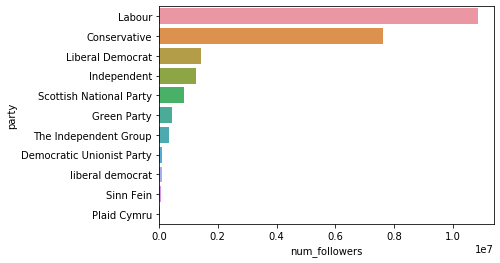

In [25]:
import seaborn as sns
sns.barplot(x='num_followers',y='party',data=party_power)

Similarly, using panda's `plot()`:

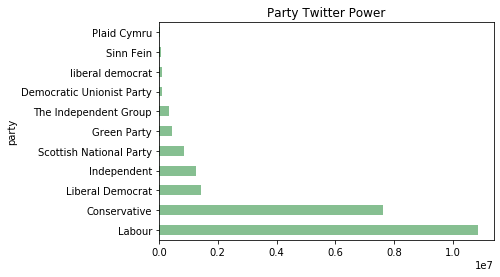

In [26]:
party_power.plot(x='party',y='num_followers'
                ,kind='barh'
                ,title='Party Twitter Power'
                ,legend=False
                ,color = '#86bf91'
                )

## Part 3: Processing Text Content

### 3.1 Prepare a Profanity Set

* We will use <http://staffwww.dcs.shef.ac.uk/people/G.Gorrell/publications-materials/abuse-terms.txt> as a source of abuse terms.
* Firstly, we pass the url to panda's `read_csv`, specifying which rows to skip.
* Then we use a regular expression to clean the terms from any redundant information
* Remove nouns and pronouns, and any whitespaces
* Make every term lower case
* Finally we create a list from all the abusive terms.

In [27]:
abuse_url = 'http://staffwww.dcs.shef.ac.uk/people/G.Gorrell/publications-materials/abuse-terms.txt'
abuse_tweets = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'

In [28]:
p = pd.read_csv(abuse_url,skiprows = 24,names = ['abuseword']) #skip first 24 rows, specify column name

p['abuseword'] =  p['abuseword'].apply(lambda x: re.sub(r'\t.*|\*+','', str(x))) #remove noise
p = p[~p.abuseword.str.contains("TOTAL")] # remove rows that start with TOTAL

p['abuseword'] =  p['abuseword'].str.replace('-','') #replace - with empty string
p['abuseword'] =  p['abuseword'].apply(lambda x: re.sub(r'^(a|u|you|your)\s+|\s+(you|off)$','', str(x))) #remove pronouns
p['abuseword'] =  p['abuseword'].apply(lambda x: re.sub(r'\s+','', str(x))) # remove any whitespaces
p['abuseword'] =  p['abuseword'].map(lambda x: x.lower()) #make lower case

bad_words = p['abuseword'].unique() #getting unique values
bad_words = bad_words.tolist()
bad_words = list(filter(None, bad_words)) #filter out empty strings

### 3.2 Parse Tweets

Import the dataset with labeled tweets:

In [29]:
t = pd.read_csv(abuse_tweets,usecols = ['count','hate_speech','offensive_language','neither','class','tweet'])

And rename the **tweet** column to **text**

In [30]:
t = t.rename(columns={"tweet": "text"})

Create a copy of the tweets, before the cleansing begins.

In [31]:
t['raw'] = t['text']

* We filter out any unnecessary symbols.
* We also remove any usernames that the tweet was referring to with RT or any urls
* Finally we remove any emoticons (words that start with the symbol &)

In [32]:
t['text'] = t['text'].apply(lambda x: re.sub(r'^[!]+\s*|RT\s*|&\S+|@\S+|\n+|\w+:\/\/\S+','', str(x)))

Now, we remove any sumbols that are not alphanumeric and transform the column to lower case using `lower()`:

In [33]:
t['text'] = t['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]',' ', str(x)))
t['text'] = t['text'].map(lambda x: x.lower())

We split the words in the tweets into a list of strings

In [68]:
t['list_words'] = t['text'].apply(lambda x: x.split())

t['list_words'][:3]

0    [as, a, woman, you, shouldn, t, complain, abou...
1    [boy, dats, cold, tyga, dwn, bad, for, cuffin,...
2    [dawg, you, ever, fuck, a, bitch, and, she, st...
Name: list_words, dtype: object

### 3.3 Count Abuse

* We notice that there are many variations of the same word in the dataset, like `bitches` and `bitch`. We will use a technique to map many alternatives into a single term.
* We will apply this transformation for every row in the dataframe.

In [35]:
abuse_mapping = {
    'bitches' : 'bitch', 
    'nigga' : 'nigger',
    'negro' : 'nigger', 
    'niggers': 'nigger',
    'fag': 'faggot',
    'pussies': 'pussy',
    'asses': 'ass'
}

f = lambda x: abuse_mapping.get(x, x) 

In [36]:
t['list_words'] = t['list_words'].map(lambda row: list(map(f,row) ))

Then we count how many words in the tweet are in the list of abusive terms and store it as integer in the dataframe.

In [37]:
t['abusive_counter'] = t['list_words'].apply(lambda x: sum(word in bad_words for word in x)).astype(int)

* With `groupby()` we create a Group Dataframe, which we use to find the mean, median, minimum, maximum, and sum of bad words in each class.
* `class=1` contains by far the most abusive terms. Interestingly, though, `class=2` contains a few bad words as well.

In [38]:
grouped = t.groupby('class')
grouped['abusive_counter'].agg([np.mean, np.median, np.min, np.max, np.sum])

,mean,median,amin,amax,sum
class,,,,,
0,1.061538,1,0,12,1518
1,1.005315,1,0,16,19292
2,0.051886,0,0,2,216


### 3.4 Visualize Profanity

Before we move forward, it is important to notice that the sample of tweets is not evenly distributed between the classes. The amount of tweets in `class=1` is  greater than the other two classes by a large factor.

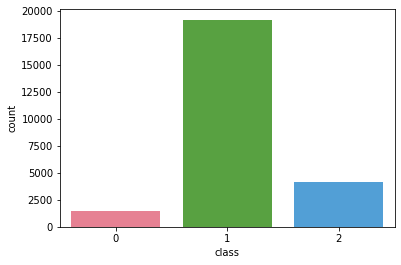

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.countplot(x = 'class',data = t, palette="husl")
plt.show()

* To visualize a histogram of bad words per class, we use a FacetGrid and set the columns to be the categorical variable `class`
* We can see that classes 0 and 1 have most of their data distributed at 1 abusive words per tweet, unlike class 2 that has most tweets contain zero bad words.

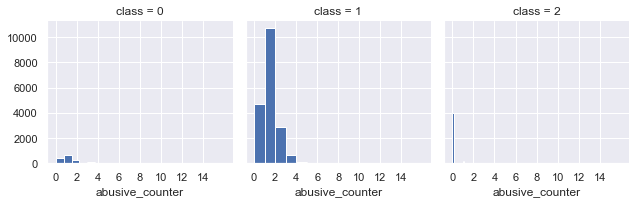

In [78]:
sns.set_style('darkgrid')
g = sns.FacetGrid(t, col="class")
g.map(plt.hist, "abusive_counter",bins=16)
g.set(xticks=np.arange(0,16,2)) # change xticks
plt.show()

Similarly, using seaborn's `distplot()` and FacetGrid with `class` for each row:

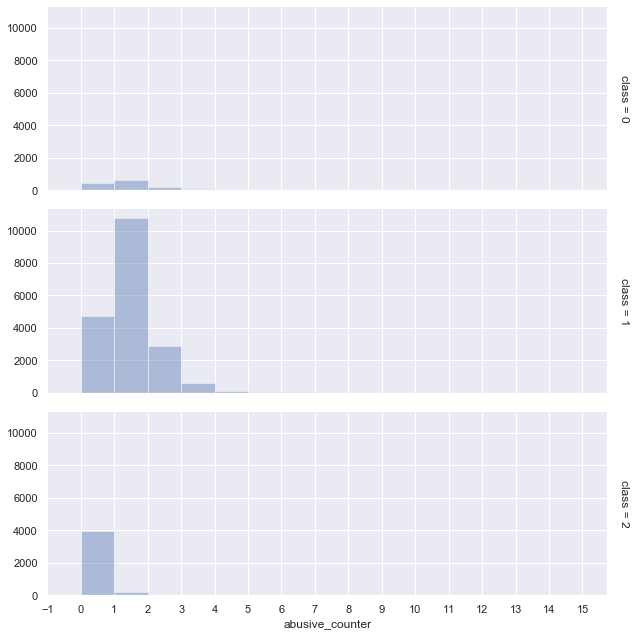

In [73]:
sns.set(style="darkgrid")
g = sns.FacetGrid(t, row="class", row_order=[0,1,2] , aspect=3,margin_titles = True)
g.map(sns.distplot, "abusive_counter", kde=False,bins=np.arange(0,16));
g.set(xticks=np.arange(-1,16)) # change xticks

* Using a `violinplot()` lets us get a better insight about the amount of bad words between the classes. 
* We can see that classes 0  and 1 are pretty similar, they have a median of 1 bad words per tweet, although, `Class=1` appears to have larger outliers.
* `Class=2` is mostly distributed around 0 bad terms per tweet as we expected.

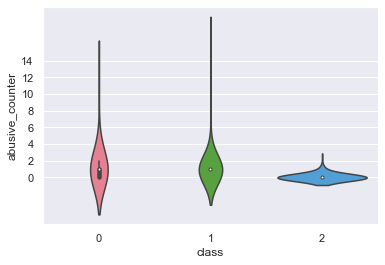

In [42]:
sns.set_style('darkgrid')
g =sns.violinplot(x = 'class',y='abusive_counter',data = t, bw=2, palette="husl")
g.set(yticks=np.arange(0,16,2)) # change xticks
plt.show()

`Striplot()`:
* To avoid overlapping points we use the `Jitter` parameter that adds some random noise to the data along the x-axis. We can see clearly the distribution of bad words per class.
* This time, the differences between `class=0` and `class=1` are more easily defined.

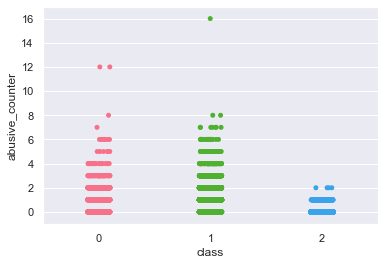

In [43]:
sns.stripplot(x = 'class',y='abusive_counter',data = t, jitter=True, palette="husl")
plt.show()

`Boxplot()`:
* With this particular graph, we can see that any bad words in `class=2` are basically outliers.
* `Class 0` has an **Interquartile Range (IQR)** of 1. **75%** of this class data contain one bad word per tweet, while **25%** zero.
* `Class 1` has so many tweets with one bad word that any other value is considered an outlier.

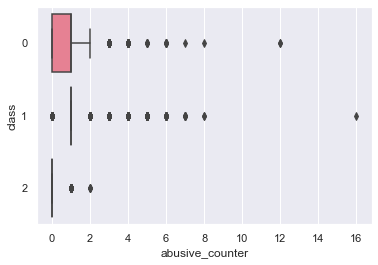

In [44]:
sns.set_style('darkgrid')
sns.boxplot(y= 'class',x='abusive_counter',data = t, orient = 'h', palette="husl")
plt.show()

### 3.5 Explore Profanity per Class

First things first, we create one list per class, which contains every word for all tweets in this class.

In [45]:
class_0 =  [val for sublist in list(t.loc[t['class']==0,'list_words'].values) for val in sublist]
class_1 =  [val for sublist in list(t.loc[t['class']==1,'list_words'].values) for val in sublist]
class_2 =  [val for sublist in list(t.loc[t['class']==2,'list_words'].values) for val in sublist]

We then create one list per class that contain **only** the bad words according to the list of abusive terms.

In [46]:
abusive_class0 = [word for word in class_0 if word in bad_words]
abusive_class1 = [word for word in class_1 if word in bad_words]
abusive_class2 = [word for word in class_2 if word in bad_words]

Finally, using `Counter` from `Collections` library, we find the 30 most common abusive terms for each class and present them in a dataframe:

In [47]:
from collections import Counter
bw = pd.DataFrame({
                    'class 0': Counter(abusive_class0).most_common(30)
                  ,'class 1': Counter(abusive_class1).most_common(30)
                  ,'class 2': Counter(abusive_class2).most_common(30)}
                 )
bw

,class 0,class 1,class 2
0,"(nigger, 315)","(bitch, 11144)","(die, 18)"
1,"(bitch, 268)","(pussy, 2185)","(cripple, 14)"
2,"(faggot, 266)","(ass, 1451)","(coon, 14)"
3,"(ass, 139)","(fuck, 1297)","(bitch, 11)"
4,"(fuck, 121)","(nigger, 1273)","(wop, 11)"
5,"(pussy, 52)","(faggot, 384)","(tranny, 11)"
6,"(kill, 32)","(dick, 320)","(kill, 10)"
7,"(queer, 30)","(cunt, 226)","(queer, 9)"
8,"(dyke, 29)","(retard, 91)","(gook, 8)"
9,"(cunt, 25)","(kill, 89)","(spook, 8)"


We can also use `WordCloud` to visualize the most common words in each class as follows:

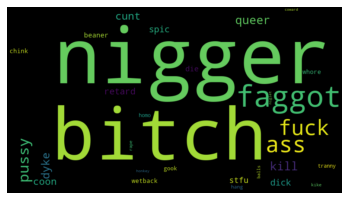

In [56]:
from wordcloud import WordCloud
d = {}
for k,v in bw['class 0']:
    d[k] = int(v)
wordcloud = WordCloud(width=900,height=500).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

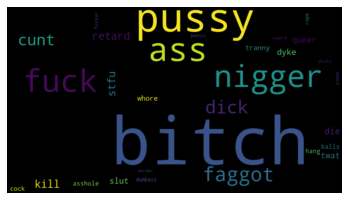

In [59]:
from wordcloud import WordCloud
d = {}
for k,v in bw['class 1']:
    d[k] = int(v)
wordcloud = WordCloud(width=900,height=500).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

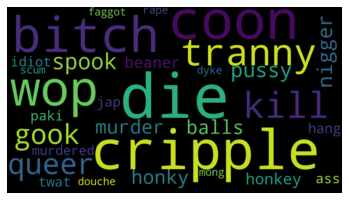

In [60]:
from wordcloud import WordCloud
d = {}
for k,v in bw['class 2']:
    d[k] = int(v)
wordcloud = WordCloud(width=900,height=500).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()